## Investigating how presence of diabetes impacts CVD risk (Framingham Score)

>The plan here is to run a regression using matching, that will help to determine the impact of having diabetes on continuous CVD risk, as described by the Framingham Risk Score. First, we will run a normal regression to show what the results are without controlling for other variables. We will then look at the impact of how matching with DAME changes these results. We will also look at the impact of age and diabetes on CVD risk.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress

df = pd.read_csv(
    "/Users/lilahduboff/Documents/Duke_Unifying_DataScience/UDS_Final_Proj/UDS_CVD_Final_Project_Rep/data/bangladesh_data.csv"
)
df.head()

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),...,Physical Activity Level,Family History of CVD,CVD Risk Level,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,F,32.0,69.1,1.71,23.6,86.2,125/79,248.0,78.0,111.0,...,Low,N,INTERMEDIARY,171.0,0.504,125.0,79.0,Elevated,140.0,17.93
1,F,55.0,118.7,1.69,41.6,82.5,139/70,162.0,50.0,135.0,...,High,Y,HIGH,169.0,0.488,139.0,70.0,Hypertension Stage 1,82.0,20.51
2,M,NaN,NaN,1.83,26.9,106.7,104/77,103.0,73.0,114.0,...,High,Y,INTERMEDIARY,183.0,0.583,104.0,77.0,Normal,0.0,12.64
3,M,44.0,108.3,1.80,33.4,96.6,140/83,134.0,46.0,91.0,...,High,Y,INTERMEDIARY,NaN,0.537,140.0,83.0,Hypertension Stage 1,58.0,16.36
4,F,32.0,99.5,1.86,28.8,102.7,144/83,146.0,64.0,141.0,...,High,N,INTERMEDIARY,186.0,0.552,144.0,83.0,Hypertension Stage 1,52.0,17.88


> First, we're going to impute the numerical columns with missing data with the mean of the variables. This seemed like the most feasible decision because the dataset is small, and it's not feasible to drop all of these columns. The only column that contains missing data that we cannot impute is risk score, so those values will ultimately be dropped. There is absolutely a way for us to calculate the expected score for individuals that are missing it, but it would require having the same chart/metrics that the researchers used, and would have to be investigated manually for each individual. 

In [55]:
# Impute missing values by filling with the mean for each respective column
df["Age"] = df["Age"].fillna(df["Age"].mean())
df["BMI"] = df["BMI"].fillna(df["BMI"].mean())
df["Total Cholesterol (mg/dL)"] = df["Total Cholesterol (mg/dL)"].fillna(
    df["Total Cholesterol (mg/dL)"].mean()
)
df["HDL (mg/dL)"] = df["HDL (mg/dL)"].fillna(df["HDL (mg/dL)"].mean())
df["Fasting Blood Sugar (mg/dL)"] = df["Fasting Blood Sugar (mg/dL)"].fillna(
    df["Fasting Blood Sugar (mg/dL)"].mean()
)
df["Systolic BP"] = df["Systolic BP"].fillna(df["Systolic BP"].mean())
df["Diastolic BP"] = df["Diastolic BP"].fillna(df["Diastolic BP"].mean())
df["Estimated LDL (mg/dL)"] = df["Estimated LDL (mg/dL)"].fillna(
    df["Estimated LDL (mg/dL)"].mean()
)

# Check for any remaining missing values
print(df.isnull().sum())

Sex                              0
Age                              0
Weight (kg)                     81
Height (m)                      67
BMI                              0
Abdominal Circumference (cm)    67
Blood Pressure (mmHg)            0
Total Cholesterol (mg/dL)        0
HDL (mg/dL)                      0
Fasting Blood Sugar (mg/dL)      0
Smoking Status                   0
Diabetes Status                  0
Physical Activity Level          0
Family History of CVD            0
CVD Risk Level                   0
Height (cm)                     74
Waist-to-Height Ratio           79
Systolic BP                      0
Diastolic BP                     0
Blood Pressure Category          0
Estimated LDL (mg/dL)            0
CVD Risk Score                  70
dtype: int64


>Ok there's still quite a few rows with missing data. Let's drop the columns we don't need (given the CDC's list of risk factors) and see if that changes anything. We'll be dropping: CVD risk score because it's a leveled version (low, med, high), and would skew results; Blood Pressure (mmHg) because we already have systolic and diastolic, and there's no simple way to convert blood pressure to a decimal/float; Waist-to-Height Ratio and Abdomical Circumference (cm) because they're not entirely relevant to what we're looking at; height and weight variables because we already have BMI, which takes both of those into account, and provides a more succinct way to measure physical stature. 

In [56]:
# we're going to drop BP (mmHg) as well, because it's a combination of systolic and diastolic
df = df.drop(
    columns=[
        "CVD Risk Level",
        "Blood Pressure (mmHg)",
        "Waist-to-Height Ratio",
        "CVD Risk Level",
        "Abdominal Circumference (cm)",
        "Height (m)",
        "Weight (kg)",
        "Height (cm)",
    ],
    errors="ignore",
)

df.head()

,Sex,Age,BMI,Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,F,32.0000,23.6,248.0,78.0,111.0,N,Y,Low,N,125.0,79.0,Elevated,140.0,17.93
1,F,55.0000,41.6,162.0,50.0,135.0,Y,Y,High,Y,139.0,70.0,Hypertension Stage 1,82.0,20.51
2,M,47.0255,26.9,103.0,73.0,114.0,N,N,High,Y,104.0,77.0,Normal,0.0,12.64
3,M,44.0000,33.4,134.0,46.0,91.0,N,N,High,Y,140.0,83.0,Hypertension Stage 1,58.0,16.36
4,F,32.0000,28.8,146.0,64.0,141.0,Y,Y,High,N,144.0,83.0,Hypertension Stage 1,52.0,17.88


### Recoding guide

Now we need to recode the Yes/No variables to binary to make it easier to model. 

- Sex: 1 for female, 0 for male
- Smoking Status: 1 for yes, 0 for no
- Diabetes Status: 1 for yes, 0 for no
- Physical Activity Level: 0 for low, 1 for moderate, 2 for high
- CVD Risk Level: 1 for intermediary or high risk, 0 for low to no risk
- Blood Pressure Category: 0 for normal; 1 for elevated; 2 for hypertension stage one; and 3 for hypertension stage two
- Family history of CVD: 0 for no; 1 for yes

In [57]:
pd.set_option("future.no_silent_downcasting", True)


df["Sex"] = df["Sex"].replace({"F": 1, "M": 0}).astype(int)
df["Smoking Status"] = df["Smoking Status"].replace({"Y": 1, "N": 0}).astype(int)
df["Diabetes Status"] = df["Diabetes Status"].replace({"Y": 1, "N": 0}).astype(int)
df["Physical Activity Level"] = (
    df["Physical Activity Level"]
    .replace({"Low": 0, "Moderate": 1, "High": 2})
    .astype(int)
)
df["Blood Pressure Category"] = (
    df["Blood Pressure Category"]
    .replace(
        {
            "Normal": 0,
            "Elevated": 1,
            "Hypertension Stage 1": 2,
            "Hypertension Stage 2": 3,
        }
    )
    .astype(int)
)
df["Family History of CVD"] = (
    df["Family History of CVD"].replace({"Y": 1, "N": 0}).astype(int)
)

In [58]:
df.head()

,Sex,Age,BMI,Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,1,32.0000,23.6,248.0,78.0,111.0,0,1,0,0,125.0,79.0,1,140.0,17.93
1,1,55.0000,41.6,162.0,50.0,135.0,1,1,2,1,139.0,70.0,2,82.0,20.51
2,0,47.0255,26.9,103.0,73.0,114.0,0,0,2,1,104.0,77.0,0,0.0,12.64
3,0,44.0000,33.4,134.0,46.0,91.0,0,0,2,1,140.0,83.0,2,58.0,16.36
4,1,32.0000,28.8,146.0,64.0,141.0,1,1,2,0,144.0,83.0,2,52.0,17.88


In [59]:
# checking the balance of people with and without diabetes
df["Diabetes Status"].value_counts()

Diabetes Status
1    777
0    752
Name: count, dtype: int64

>Now let's visually compare how the average measurements change between those with and without diabetes

In [60]:
has_diabetes = df[df["Diabetes Status"] == 1]
no_diabetes = df[df["Diabetes Status"] == 0]


def print_means(df, label):
    print(f"\nMeans for {label}:")
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            print(f"{col}: {df[col].mean():.2f}")


print_means(has_diabetes, "People with Diabetes")
print_means(no_diabetes, "People without Diabetes")


Means for People with Diabetes:
Sex: 0.51
Age: 46.79
BMI: 28.87
Total Cholesterol (mg/dL): 199.35
HDL (mg/dL): 55.61
Fasting Blood Sugar (mg/dL): 117.80
Smoking Status: 0.51
Diabetes Status: 1.00
Physical Activity Level: 1.04
Family History of CVD: 0.50
Systolic BP: 125.29
Diastolic BP: 82.97
Blood Pressure Category: 1.95
Estimated LDL (mg/dL): 113.06
CVD Risk Score: 18.05

Means for People without Diabetes:
Sex: 0.50
Age: 47.27
BMI: 28.05
Total Cholesterol (mg/dL): 197.71
HDL (mg/dL): 56.81
Fasting Blood Sugar (mg/dL): 117.16
Smoking Status: 0.52
Diabetes Status: 0.00
Physical Activity Level: 0.99
Family History of CVD: 0.48
Systolic BP: 125.98
Diastolic BP: 82.86
Blood Pressure Category: 1.96
Estimated LDL (mg/dL): 109.99
CVD Risk Score: 15.85


>While looking at the numerical columns, it actually seems like most of the variables are pretty equal for the two groups. The few I may check are Estimated LDL, and Physical Activity Level. Ones that seem ok but could check regardless are Age, and Total Cholesterol. CVD risk score has an obvious difference as well, but as this is our outcome variable, I want to run more tests without definitively stating that the two groups are different in their CVD risk.

In [61]:
diabetes_ldl = df[df["Diabetes Status"] == 1]["Estimated LDL (mg/dL)"].dropna()
no_diabetes_ldl = df[df["Diabetes Status"] == 0]["Estimated LDL (mg/dL)"].dropna()

t_stat, p_value = stats.ttest_ind(diabetes_ldl, no_diabetes_ldl)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 1.0434
P-value: 0.2969


In [62]:
diabetes_phys_act = df[df["Diabetes Status"] == 1]["Physical Activity Level"].dropna()
no_diabetes_phys_act = df[df["Diabetes Status"] == 0][
    "Physical Activity Level"
].dropna()

t_stat, p_value = stats.ttest_ind(diabetes_phys_act, no_diabetes_phys_act)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 1.3359
P-value: 0.1818


>Ok great, these ones had the largest differences and they are not significant! Now let's check the group counts with a contingency table

In [63]:
# Crosstab by sex
pd.crosstab(df["Diabetes Status"], df["Sex"], margins=True)

Sex,0,1,All
Diabetes Status,,,
0,374,378,752
1,382,395,777
All,756,773,1529


In [64]:
# crosstab by smoking status
pd.crosstab(df["Diabetes Status"], df["Smoking Status"], margins=True)

Smoking Status,0,1,All
Diabetes Status,,,
0,362,390,752
1,378,399,777
All,740,789,1529


In [65]:
# crosstab by family history of CVD
pd.crosstab(df["Diabetes Status"], df["Family History of CVD"], margins=True)

Family History of CVD,0,1,All
Diabetes Status,,,
0,392,360,752
1,388,389,777
All,780,749,1529


In [66]:
df = df.dropna(subset=["CVD Risk Score"])

df.isnull().sum()

Sex                            0
Age                            0
BMI                            0
Total Cholesterol (mg/dL)      0
HDL (mg/dL)                    0
Fasting Blood Sugar (mg/dL)    0
Smoking Status                 0
Diabetes Status                0
Physical Activity Level        0
Family History of CVD          0
Systolic BP                    0
Diastolic BP                   0
Blood Pressure Category        0
Estimated LDL (mg/dL)          0
CVD Risk Score                 0
dtype: int64

### Standard Linear Regression

> Now, we'll get to the meat and potatoes of the analysis, modeling cvd risk with a standard linear regression. As the data is pretty balanced, we won't use matching initially. After assessing the results, we will compare these models to one using a matched dataset

>This first model uses all variables to see how they vary in terms of impact on CVD risk. We will limit the following models to age and diabetes, as we're interested in how early-onset diabetes could impact CVD risk.

In [67]:
df.columns = df.columns.str.replace(" ", "_")

df["estimated_LDL"] = df["Estimated_LDL_(mg/dL)"]
df["hdl"] = df["HDL_(mg/dL)"]
df["total_cholesterol"] = df["Total_Cholesterol_(mg/dL)"]
df["fasting_blood_sugar"] = df["Fasting_Blood_Sugar_(mg/dL)"]

model = smf.ols(
    "CVD_Risk_Score ~ Diabetes_Status + Sex + Age + BMI + total_cholesterol + hdl + fasting_blood_sugar + Smoking_Status + Physical_Activity_Level + Family_History_of_CVD + Systolic_BP + Diastolic_BP + Blood_Pressure_Category + estimated_LDL",
    data=df,
).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         CVD_Risk_Score   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     3913.
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:24:00   Log-Likelihood:                -697.40
No. Observations:                1459   AIC:                             1425.
Df Residuals:                    1444   BIC:                             1504.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

> So we already knew that the data was super balanced, and also appears very linear. We see that diabetes emerges as the largest predictor of cvd risk.

### Analysis of Age and Diabetes on CVD Risk

> Now we'll use more specified models to assess how age and diabetes interact to influence CVD risk.

In [68]:
# Age vs CVD Risk Score
df_clean = df[["Age", "CVD_Risk_Score"]].dropna()

slope, intercept, r_value, p_value, std_err = linregress(
    df_clean["Age"], df_clean["CVD_Risk_Score"]
)

r_squared = r_value**2
print(f"R-squared: {r_squared:.4f}")
print(f"Standard error: {std_err:.4f}")

R-squared: 0.0028
Standard error: 0.0053


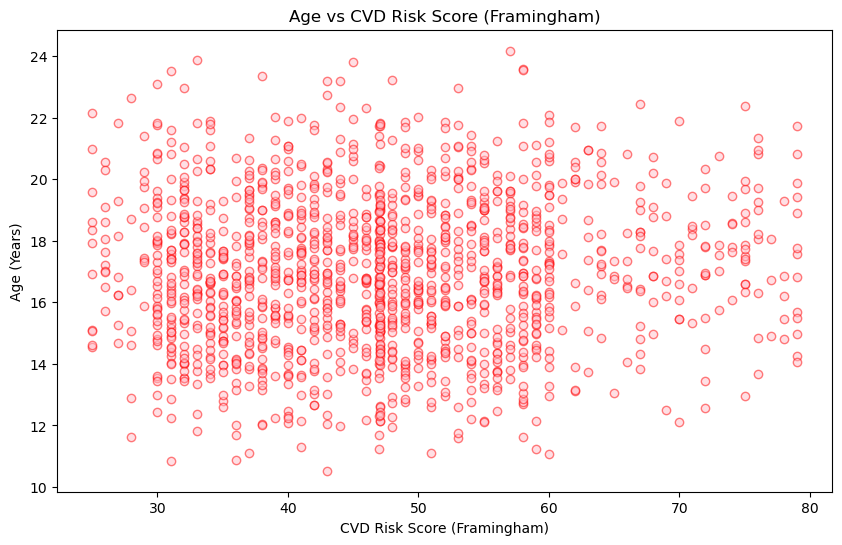

In [69]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Age"], df["CVD_Risk_Score"], alpha=0.5, color="pink", edgecolors="red")
plt.xlabel("CVD Risk Score (Framingham)")
plt.ylabel("Age (Years)")
plt.title("Age vs CVD Risk Score (Framingham)")
plt.show()

In [70]:
# Difference in CVD Risk Score by Diabetes Status
statistic, pvalue = stats.ttest_ind(
    has_diabetes["CVD Risk Score"].dropna(), no_diabetes["CVD Risk Score"].dropna()
)

print("T-statistic:", statistic)
print(f"P-value is {pvalue:.5f}")

T-statistic: 19.356519533425136
P-value is 0.00000


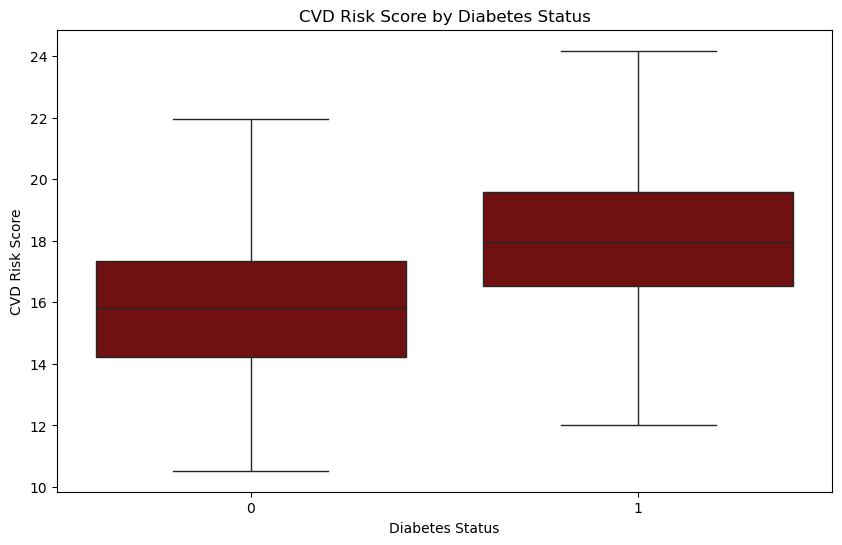

In [71]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Diabetes_Status", y="CVD_Risk_Score", data=df, color="maroon")
plt.xlabel("Diabetes Status")
plt.ylabel("CVD Risk Score")
plt.title("CVD Risk Score by Diabetes Status")
plt.show()

In [72]:
model = smf.ols(
    "CVD_Risk_Score ~ Diabetes_Status + Age + Diabetes_Status:Age", data=df
).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         CVD_Risk_Score   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     127.9
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           1.57e-73
Time:                        18:24:00   Log-Likelihood:                -3198.1
No. Observations:                1459   AIC:                             6404.
Df Residuals:                    1455   BIC:                             6425.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              15.1914    

> Again with the specialized model we find that diabetes is a significant predictor of cvd risk, but age and the interaction between the two are not. Let's now calculate the average treatment effect of diabetes on CVD risk:

In [73]:
# split
treated = df[df["Diabetes_Status"] == 1]
control = df[df["Diabetes_Status"] == 0]

# get weighted mean
treated_mean = np.average(treated["CVD_Risk_Score"])
control_mean = np.average(control["CVD_Risk_Score"])

# ATE
ate = treated_mean - control_mean

# print
print(f"ATE: {ate:.4f}")

ATE: 2.2030


### Now we repeat the analysis with matching:

In [ ]:
# Creating age categories by rounding to the nearest 10
df["age_category"] = df["Age"].apply(lambda r: r // 10 * 10)

df["age_category"] = df["age_category"].astype("int64")
print(df["age_category"].value_counts())

age_category
40    457
30    398
50    353
60    119
70     85
20     47
Name: count, dtype: int64


In [ ]:
#prepping data for flame
df_flame = df[
    [
        "Diabetes_Status",
        "CVD_Risk_Score",
        "age_category",
    ]
]

In [ ]:
#making sure we have the right number of observations
df_flame["Diabetes_Status"].value_counts()

Diabetes_Status
1    737
0    722
Name: count, dtype: int64

In [ ]:
import dame_flame

# Create the model
model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
)

# Fit the model
model.fit(
    df_flame,
    treatment_column_name="Diabetes_Status",
    outcome_column_name="CVD_Risk_Score",
)

# Make predictions
result = model.predict(df_flame)

print(result)

Completed iteration 0 of matching
	Number of matched groups formed in total:  6
	Unmatched treated units:  0 out of a total of  737 treated units
	Unmatched control units:  0 out of a total of  722 control units
	Number of matches made this iteration:  1459
	Number of matches made so far:  1459
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  9.382612486928142
1459 units matched. We finished with no more treated units to match
     age_category
0            30.0
1            50.0
2            40.0
3            40.0
4            30.0
...           ...
1524         40.0
1525         70.0
1526         30.0
1527         70.0
1528         70.0

[1459 rows x 1 columns]


/opt/miniconda3/lib/python3.12/site-packages/dame_flame/dame_algorithm.py:156: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  weights['weights'][unique_units[index]] += occurrences[index]


In [78]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert np.isclose(better.loc[better[t] == 0, "weights"].sum(), num_control_obs)

    return better

In [ ]:
#call the function from class to get dataframe
matched_df = get_dataframe(model, result)

matched_df

/var/folders/gk/rvx2k2rs1yvbbbfgbclm80600000gn/T/ipykernel_36948/2220943063.py:17: FutureWarning: The provided callable <function sum at 0x114255ee0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)


,Diabetes_Status,CVD_Risk_Score,age_category,match_group,match_group_size,weights
0,1,17.930,30,1.0,398.0,1.000000
1,1,20.510,50,3.0,353.0,1.000000
2,0,12.640,40,2.0,457.0,1.112403
3,0,16.360,40,2.0,457.0,1.112403
4,1,17.880,30,1.0,398.0,1.000000
...,...,...,...,...,...,...
1524,0,14.300,40,2.0,457.0,1.112403
1525,0,14.805,70,5.0,85.0,0.830570
1526,1,18.251,30,1.0,398.0,1.000000
1527,0,15.316,70,5.0,85.0,0.830570


In [ ]:
# rerunning the model on age and diabetes with the matched data
smf.wls(
    "CVD_Risk_Score ~ C(Diabetes_Status) + C(age_category)",
    matched_df,
    weights=matched_df["weights"],
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         CVD_Risk_Score   R-squared:                       0.218
Model:                            WLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     67.51
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           3.31e-74
Time:                        18:24:01   Log-Likelihood:                -3195.3
No. Observations:                1459   AIC:                             6405.
Df Residuals:                    1452   BIC:                             6442.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  16.3882      0.302     54.355      0.000      15.797      16.980
C(Diabetes_Status)[T.1]     2.2099      0.113     19.501      0.000       1.988       2.432
C(age_category)[T.30]      -0.6690      0.316     -2.116      0.035      -1.289      -0.049
C(age_category)[T.40]      -0.6912      0.312     -2.215      0.027      -1.303      -0.079
C(age_category)[T.50]      -0.6486      0.317     -2.043      0.041      -1.271      -0.026
C(age_category)[T.60]       0.1572      0.360      0.436      0.663      -0.550       0.864
C(age_category)[T.70]       0.0322      0.385      0.084      0.933      -0.723       0.788
==============================================================================
Omnibus:                       11.010   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.011
Skew:                           0.155   Prob(JB):                      0.00670
Kurtosis:                       2.738   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# calculating the ATE for the matched data
matched_df = matched_df.dropna(subset=["match_group"])
treated = matched_df[matched_df["Diabetes_Status"] == 1]
control = matched_df[matched_df["Diabetes_Status"] == 0]

# weighted mean
treated_mean = np.average(treated["CVD_Risk_Score"], weights=treated["weights"])
control_mean = np.average(control["CVD_Risk_Score"], weights=control["weights"])

# ATE
ate = treated_mean - control_mean

# se
treated_var = np.average(
    (treated["CVD_Risk_Score"] - treated_mean) ** 2, weights=treated["weights"]
)
control_var = np.average(
    (control["CVD_Risk_Score"] - control_mean) ** 2, weights=control["weights"]
)
se = np.sqrt(
    treated_var / treated["weights"].sum() + control_var / control["weights"].sum()
)

# 95% CI
ci_lower = ate - 1.96 * se
ci_upper = ate + 1.96 * se

print(f"Matched ATE: {ate:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

Matched ATE: 2.2099
95% CI: [1.9864, 2.4333]
